# Ernesto Antonio Reyes Ramírez

# Visión Computacional

# Tarea 4

In [1]:
#Importamos las librerias que vamos a utilizar 
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

In [2]:
#Calculamos la matriz K de parámetros intrinsecos de la cámara 

h,w,f_u, f_v, cx,cy = np.load('hwf_cxcy.npy')
K = np.array([[f_u[0], 0, cx[0]],[0, f_v[0], cy[0]],[0,  0,  1]])

# 1. Implementar a función que estime la matriz fundamental 


In [3]:
#Comenzamos con el proceso de 
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

# Las dos imagenes sobre las cuales vamos a trabajar
img1 = cv2.imread("IMG_1268.png",0)
img2 = cv2.imread("IMG_1269.png",0)

In [4]:
# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)

keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
# Match features and get the list of matches
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = list(matcher.match(descriptors1, descriptors2, None))
# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)
# Remove not so good matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]
print("Good matches found: {}".format(numGoodMatches))

Good matches found: 75


In [5]:
# Ubicación de los buenos emparejamientos 
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

In [6]:
#Función para normalizar un punto
def normalizePoint(p, K):
    pp = np.array([p[0],p[1], 1])
    return np.linalg.inv(K) @ pp

In [7]:
#Función que implementa el algoritmo de 7 puntos normalizado
def seven_point_normalized_algorithm(pts1, pts2, K):
    
    # Construir la matriz A
    A = np.zeros((pts1.shape[0], 9))
    for i in range(pts1.shape[0]):
        p1 = [pts1[i,0], pts1[i,1]]
        p2 = [pts2[i,0], pts2[i,1]]
        np1 = normalizePoint(p1, K)
        np2 = normalizePoint(p2, K)
        A[i] = np.array([np2[0]*np1[0],np2[0]*np1[1],np2[0]*1,np2[1]*np1[0],np2[1]*np1[1],np2[1]*1,np1[0],np1[1],1])
    
    # Resolver la ecuación Ax = 0 usando SVD
    U, S, V = np.linalg.svd(A)
    F1 = V.T[:,-1].reshape(3, 3)
    F2 = V.T[:,-2].reshape(3, 3)
    
    def Funt(l):
        return np.linalg.det(l*F1+(1-l)*F2)
    
    lamb = fsolve(Funt,0)
    
    F_mat = lamb*F1 + (1-lamb)*F2
    
    # Desnormalizar F
    dF = np.linalg.inv(K).T @ F_mat @ np.linalg.inv(K)
        
    return dF

In [8]:
#Función que implementa el algoritmo de RANSAC utilizando el algoritmo de 7 puntos
def findFundamentalMat(points1, points2, K ,tol=.001): 
    max_inlie = 0
    max_iter = 1000
    
    F        = np.zeros((3, 3), dtype=float)
    p        = np.ones((3, points1.shape[0]))
    p[:2, :] = points1.T
    q        = np.ones((3, points2.shape[0]))
    q[:2, :] = points2.T
    
    error = np.zeros(points1.shape[0])
    idx = np.arange(points1.shape[0])
    
    #RANSAC
    pairs = 7
    for i in range(max_iter):
        #Puntos random
        np.random.shuffle(idx)
        #Matriz fundamental para estos puntos
        f = seven_point_normalized_algorithm(points1[idx[:pairs]],points2[idx[:pairs]], K)

        #Error
        for j in range(points1.shape[0]):
            error[j] = q[:, j] @ (f @ p[:, j])
        inliers = np.sum(np.absolute(error) < tol)
        #Decision
        if inliers > max_inlie:
            F = f
            max_inlie = inliers
            
    #Ultima estimación con los inliers
    for j in range(points1.shape[0]):
        error[j] = q[:, j] @ (F @ p[:, j])
    idx = np.argsort(np.absolute(error))
    
    # Nos quedamos solo con los inliers
    pts1 = points1[idx[:max_inlie]]
    pts2 = points2[idx[:max_inlie]]
        
    return F, pts1, pts2

In [10]:
F, points1_inliers, points2_inliers = findFundamentalMat(points1, points2, K ,tol=.001)

In [11]:
print(points1_inliers.shape,points2_inliers.shape)

(68, 2) (68, 2)


In [12]:
def drawlines(img1,img2,lines,pts1,pts2):
    radio = 40
    circle_width=80
    line_width=20
    r,c = img1.shape
    nimg1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    nimg2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):

        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        cv2.line(nimg1, (x0,y0), (x1,y1), color,line_width)
        cv2.circle(nimg1,pt1,radio,color,circle_width)
        cv2.circle(nimg2,pt2,radio,color,circle_width)
    return nimg1,nimg2

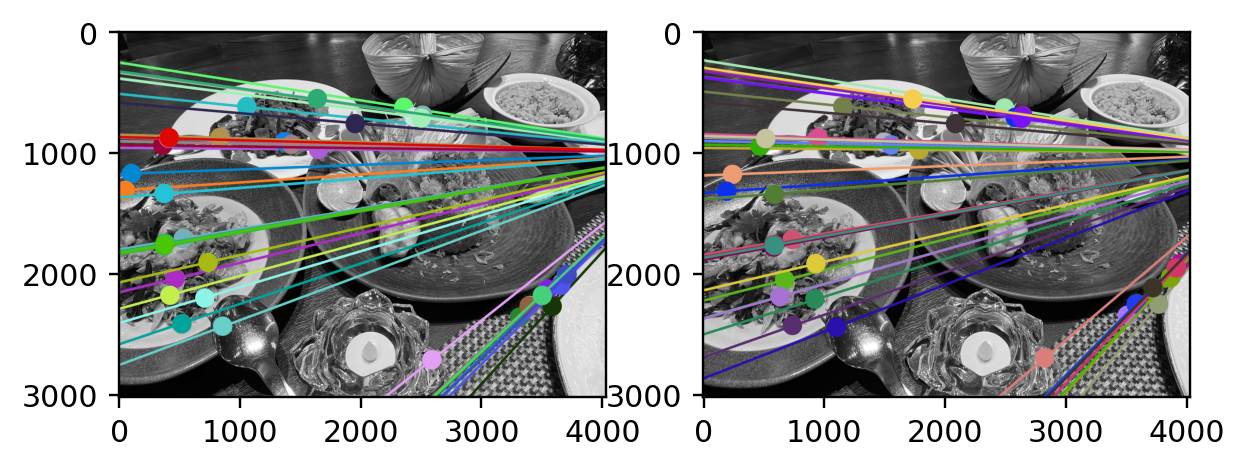

In [13]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(points2_inliers.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,points1_inliers.astype(int),points2_inliers.astype(int))
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(points1_inliers.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,points2_inliers.astype(int),points1_inliers.astype(int))
fig, ax=plt.subplots(dpi=216)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# 2. Explica (geométricamente y algebraicamente) que le pasa a la matriz fundamental cuando no hay traslación entre las cámaras (solo rotación). 

Sol: Cuando no tenemos traslación quiere decir que los centros de las cámaras $c_1$ y $c_2$ se ubican en el mismo lugar, y solo estpan dirigidos en direcciones diferentes. Se tiene en este caso que las líneas epipolares son paralelas. 

Geométricamente, esto significa que la linea epipolar de un punto en una imagen se puede determinar a partir de su correspondiente en la otra imagen simplemente dibujando una línea que pasa por el punto en una imagen y su correspondiente en la otra imagen, y que es perpendicular a la línea que une los centros de las cámaras. En otras palabras, la linea epipolar es la línea de intersección del plano de la imagen y el plano que contiene las líneas de visión de los dos puntos correspondientes.

Algebraicamente notemos lo siguiente. Recordemos que la fórmula para la matriz fundamental es:

$$
F = K_2^{-T} * [t]_x * R * K_1^{-1}
$$

donde $K_1,K_2$ son las matrices de parámetros intrínsecos, $t$ el vector de traslaciónentre las cámaras y $R$ la matriz de rotación entre las cámaras. Dado que no hay traslación, se tiene que $t=[0,0,0]^T$, de modo que sustituyendo en la fórmula de $F$ obtenemos:

$$
F = K_2^{-T} * \textbf{0} * R * K_1^{-1} = \textbf{0}
$$

Esta matriz fundamental simplificada indica que la restricción epipolar se satisface trivialmente, lo cual es consistente con la geometría de la escena donde no hay movimiento en la dirección de la línea de base entre las cámaras.

 # 3. Utiliza un par de imágenes no distorsionadas del siguiente conjunto de datos proporcionado. 
 
 -Estima la matriz esencial 
 
 -Deduce (bajo escalamiento) el desplazamiento 3D entre cámaras. 
 
 -Triangula los puntos clave coincidentes en puntos 3D, como se describe en la secciónn 10. 
 
 -Grafica los puntos 3D obtenidos.

In [14]:
# Las dos imagenes sobre las cuales vamos a trabajar
img3 = cv2.imread("IMG_1268.png",0)
img4 = cv2.imread("IMG_1269.png",0)

In [15]:
# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)

keypoints1, descriptors1 = orb.detectAndCompute(img3, None)
keypoints2, descriptors2 = orb.detectAndCompute(img4, None)
# Match features and get the list of matches
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = list(matcher.match(descriptors1, descriptors2, None))
# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)
# Remove not so good matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]
print("Good matches found: {}".format(numGoodMatches))

Good matches found: 75


In [16]:
# Ubicación de los buenos emparejamientos 
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

In [17]:
F, mask = cv2.findFundamentalMat(points1,points2,cv2.FM_RANSAC)
print(F)

[[-1.57040822e-07  7.36733923e-06 -3.09779496e-02]
 [-4.15041329e-06 -2.28186439e-06  5.44433638e-01]
 [ 2.94855734e-02 -5.42880049e-01  1.00000000e+00]]


In [18]:
# We select only inlier points among points1 and point2
points1_inliers = points1[mask.ravel()==1]
points2_inliers = points2[mask.ravel()==1]
print(points1_inliers.shape,points2_inliers.shape)

(57, 2) (57, 2)


In [19]:
#Calculamos la matriz esencial 

E = K.T @ F @K
print(E)
#Realizamos descomposicion SVD
U, D, V = np.linalg.svd(E.astype(np.float32))
#Matriz auxiliar W
W= np.array( [[0,1,0],
            [-1,0,0],
             [0,0,1]])
P1 = np.column_stack((U@W@(V.T),U[:,2]))
P2 = np.column_stack((U@W@(V.T),-U[:,2]))
P3 = np.column_stack((U@(W.T)@(V.T),U[:,2]))
P4 = np.column_stack((U@(W.T)@(V.T),U[:,2]))
Ps=[P1,P2,P3,P4]

[[-1.58394501e+00  7.43084511e+01 -6.67157163e+01]
 [-4.18618952e+01 -2.30153387e+01  1.69216085e+03]
 [ 7.42195206e+01 -1.68671960e+03  4.16532066e+00]]


In [20]:
#Deducimos el desplazamiento 3D entre las cámaras

[ps, R, t, mask] = cv2.recoverPose(E,points1,points2)

In [21]:
#vamos a calcular las mtrices de proyección

P1 = np.zeros((3,4)) 
P2 = np.zeros((3,4))

#[I | 0]
P1[:,0:3] = np.identity(3)
P1[:,3] = np.zeros(3)

#[R|T]
P2[:,0:3] = R
P2[:,3] = t.T

P1 = K@P1
P2 = K@P2 

In [22]:
#Triangulamos los puntos 3D

triangulate_points = cv2.triangulatePoints(P1,P2,points1.T,points2.T)

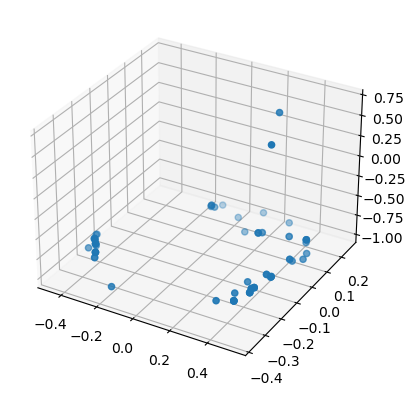

In [23]:
X,Y,Z = triangulate_points[0], triangulate_points[1], triangulate_points[2]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(X, Y, Z)
plt.show()

# 4. Demostrar que en el caso general de dos cámaras, dos puntos $p$,$p^{\prime}$ proyecciones del mismo punto $3D$ satisfacen

$$
p^{\prime} \propto K^{\prime} R K^{-1} p + \frac{1}{z}K^{\prime} t,
$$

donde Z es un escalar. 

-¿Cómo se interpretaría el primer término?

-¿Cómo se interpretaría Z?

-Suponiendo que hay puntos de la escena que puedes indetificar como siendo al infinito, se podría proponer un algoritmo para estimar R?

-Suponinedo que ahora R es conocido, ¿cómo se podría usar esa misma relación de arriba para estimar t?

Sol: Colocamos el centro de las coordenadas del mundo en en las coordenadas de la primera cámara. Con este supuesto, tenemos que las proyecciones del punto $X$ en 3D que estamos considerando son,

$$
p \propto KX
$$

y

$$
p^{\prime} \propto K^{\prime} R X + K^{\prime} t
$$

Dado que la primera ecuación nos dice que es proporcional, llamemos a esta constante de proporcional $1/z$. De modo que,

$$
p = \frac{1}{z} KX 
$$

y

$$
ZK^{-1} p = X
$$

Ahora sustituimos lo anterior en la realción de $p^{\prime}$,

$$
p^{\prime} \propto K^{\prime} R (ZK^{-1} p) + K^{\prime} t = ZK^{\prime} R K^{-1} p + K^{\prime} t 
$$

Ya que la relación anterior es de proporcionalidad y no de igualdad, multiplicamos lo anterior por $1/z$ manteniendo dicha relación:

$$
p^{\prime} \propto K^{\prime} R K^{-1} p + \frac{1}{z}K^{\prime} t 
$$

1. La multiplicación $K^{\prime}RK^{-1}p$ implica que el punto p se transforma primero en el sistema de coordenadas de la cámara mediante la matriz de rotación R y luego se proyecta en el plano de la imagen mediante la matriz de calibración K'.

El primer término de la relación de proyección de la cámara se refiere a la transformación geométrica que describe cómo un punto 3D en el espacio se proyecta en el plano de la imagen de la cámara, sin considerar la posición de la cámara en relación al mundo 3D.


2. Z es la constante de profundidad. 

3. Dado que las proyecciones de un punto 3D en dos cámaras diferentes se relacionan mediante una matriz de rotación R y un vector de traslación t, podemos utilizar la información de las proyecciones de los puntos en las dos cámaras para estimar la matriz de rotación R.

Supongamos que tenemos los puntos p y q, que son proyecciones de un mismo punto 3D X en dos cámaras diferentes. Podemos escribir la relación entre las proyecciones de los puntos p y q como:

$$q = R * p + t$$

donde R es la matriz de rotación que queremos estimar y t es el vector de traslación. Como sabemos que algunos puntos de la escena van al infinito, podemos asumir que la tercera coordenada del punto 3D X es igual a cero. Esto significa que podemos escribir:

$$X = [x,y,0, 1]^T$$

donde x e y son las coordenadas del punto en el plano imagen.

Entonces, podemos escribir las proyecciones de los puntos p y q como:

$$p = K_1 * [I | 0] * X$$
$$q = K_2 * [R | t] * X$$

donde K_1 y K_2 son las matrices de calibración de las dos cámaras, y $[I | 0]$ es una matriz de 3x4 que representa la matriz de proyección de una cámara sin rotación ni traslación.

Podemos reorganizar estas ecuaciones para obtener:
$$X = [x,y, 0, 1]^T = (K_1^{-1} [I|0]p + K_2^{-1} [R t] q) / 2$$

donde hemos utilizado las matrices de calibración inversas para obtener las coordenadas del punto 3D X.

Ahora, podemos utilizar los puntos de la escena que van al infinito para estimar la matriz de rotación R. Para hacer esto, podemos seleccionar varios puntos de la escena que van al infinito y calcular las proyecciones correspondientes en las dos cámaras. A partir de estas proyecciones, podemos estimar la matriz de rotación R utilizando técnicas de mínimos cuadrados, como la descomposición en valores singulares (SVD).

El algoritmo sería el siguiente:

Seleccionar varios puntos de la escena que van al infinito.
Para cada punto, calcular las proyecciones correspondientes en las dos cámaras.
Estimar la matriz de rotación R utilizando técnicas de mínimos cuadrados, como la descomposición en valores singulares (SVD).

4. Supongamos que conocemos la matriz de rotación R. Despejamos t de la relación del punto 1:

$$
t \propto zK^{-1}p^{\prime} - z K^{-1}K^{\prime} R K^{-1}
$$

Dado que conocemos la matriz de rotación $R$ y las matrices de proyecciones de las cámaras $K,K^{\prime}$, podemos calcular $t$, bajo un factor de escala, utilizando la relación anterior. 